In [58]:
import numpy as np
import torch
import torch.nn as nn

from transformers import ViTForImageClassification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

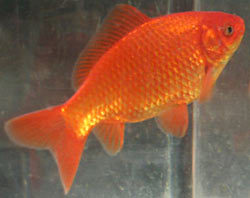

In [76]:
from PIL import Image
import requests

image = Image.open("/home/lukasz/binary-hyper-maml/filelists/miniImagenet/ILSVRC/Data/CLS-LOC/train/n01443537/n01443537_339.JPEG")
image

In [77]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

In [78]:
with torch.no_grad():
  outputs = model.vit(pixel_values)
outputs

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-1.5847,  0.0993, -0.4515,  ..., -0.2056,  0.7845,  0.2123],
         [-1.6045,  0.0386,  0.0327,  ...,  0.2588,  0.9416, -0.5189],
         [-1.4281, -0.3243,  0.1673,  ...,  0.7642,  1.7191, -0.4652],
         ...,
         [-1.4884, -0.5427, -0.3304,  ...,  0.6213,  0.9805, -0.2333],
         [-1.5206, -0.1141, -0.4632,  ...,  0.2637,  0.5139, -0.3056],
         [-1.5969,  0.1862, -0.7569,  ...,  0.3543,  0.6087, -0.4482]]],
       device='cuda:0'), pooler_output=None, hidden_states=None, attentions=None)

In [79]:
sequence_output = outputs[0][:, 0, :]

In [80]:
sequence_output_np = sequence_output.cpu().detach().numpy()
np.save("emb.npy", sequence_output_np)
embedding = np.load("emb.npy")
embedding = torch.Tensor(embedding).cuda()

In [81]:
logits = model.classifier(embedding)

In [82]:
prediction = logits.argmax(-1)
print("Predicted class:", model.config.id2label[prediction.item()])

Predicted class: goldfish, Carassius auratus
